# Exploring LDA Visualizations

In [1]:
import os
from pprint import pprint
import pickle
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
from gensim import corpora, models

In [2]:
%load_ext watermark
%config InlineBackend.figure_format = 'retina'
%watermark --iso8601 -u -v -m -iv 

Last updated: 2024-03-01T18:35:42.065780-05:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.16.1

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.8.2
gensim    : 4.3.2
pandas    : 2.0.3



<br>

## Data Acquisition

In [3]:
# Path for the final split csv file
file_path: str = "/Users/nitingupta/Desktop/OTB/final_splits_Nov3.csv"

In [4]:
df: pd.DataFrame = pd.read_csv(file_path, index_col = 0, usecols=['id', 'sentence'])

# Get the years
df['year']: pd.Series = df.index.str.split("_").str[0]
df.set_index('year', inplace=True)
df.reset_index(inplace=True)

print(f"Number of rows in the DataFrame: {df.shape[0]:,}")

Number of rows in the DataFrame: 403,481


In [5]:
df.head()

,year,sentence
0,1868-69,AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...
1,1868-69,"Whereas, by an Act of Congress, approved the t..."
2,1868-69,Beit enacted by the Senate and House of Repres...
3,1868-69,"Upon the passage of this Act, the Governor of ..."
4,1868-69,"In the Senate House, the twentysecond day of J..."


<br>

## Pre Processing
Most of the preprocessing done below is explained in `LDA.ipynb`.

In [6]:
# Read the cleaned sentences file
with open('checkpoint/cleaned_sentences.pkl', 'rb') as in_file:
    cleaned_sents: List[List[str]] = pickle.load(in_file)

In [7]:
# Create a dictionary: a mapping between words and their integer ids
dictionary = corpora.Dictionary(cleaned_sents)

# Filter extremes
dictionary.filter_extremes(no_below=10, no_above=1, keep_n=None)
print(f"Length of the dictionary after filtering: {len(dictionary):,}")

# Convert document into the bag-of-words format
corpus = [dictionary.doc2bow(text) for text in cleaned_sents]

Length of the dictionary after filtering: 17,034


In [8]:
# Path for the LDA model
model_path: str = os.path.join('checkpoint', 'topic_model.lda')

# Load the LDA model
lda_model = models.ldamodel.LdaModel.load(model_path)

In [9]:
# Get the 2 most significant topics.
# Show in word-probability pairs.
for topic in lda_model.show_topics(formatted=False)[:2]:
    pprint(topic)

(0,
 [('dollar', 0.042293984),
  ('road', 0.03987477),
  ('highway', 0.03410004),
  ('department', 0.01259054),
  ('township', 0.012436719),
  ('commissioner', 0.011775412),
  ('bridge', 0.0106536485),
  ('system', 0.010478118),
  ('le', 0.009687982),
  ('fifty', 0.00831837)])
(1,
 [('district', 0.04548859),
  ('school', 0.04206428),
  ('bond', 0.030950587),
  ('tax', 0.029794844),
  ('interest', 0.018489987),
  ('property', 0.017764106),
  ('trustee', 0.016066454),
  ('note', 0.011515265),
  ('fund', 0.011132653),
  ('treasurer', 0.009877538)])


In [10]:
# Open a text file in write mode
with open("checkpoint/lda_topics.txt", "w") as file:
    # Show in word-probability pairs.
    for topic_idx, topic in lda_model.show_topics(formatted=False):
        # Write the topic index to the file
        file.write(f"Topic {topic_idx}:\n")
        # Write each word-probability pair to the file
        for word, prob in topic:
            file.write(f"{word}: {prob}\n")
        # Write a separator between topics
        file.write("\n")

<br>

## Visualizations

### Stack Plot for Topic Distribution over Time

In [11]:
# Get the topic distribution for each document as a list of (topic_id, topic_probability) 2-tuples.
document_topics = [lda_model.get_document_topics(doc) for doc in corpus]
print(f"Number of topics (mathces the number of documents, i.e. rows): {len(document_topics):,}")

Number of topics (mathces the number of documents, i.e. rows): 403,481


In [12]:
# Extracting the dominant topic for each document
dominant_topics: List[int] = [max(topics, key=lambda x: x[1])[0] for topics in document_topics]

In [13]:
# Add the dominant topic information back to the DataFrame
df['dominant_topic'] = dominant_topics

In [14]:
df.head()

,year,sentence,dominant_topic
0,1868-69,AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...,7
1,1868-69,"Whereas, by an Act of Congress, approved the t...",7
2,1868-69,Beit enacted by the Senate and House of Repres...,5
3,1868-69,"Upon the passage of this Act, the Governor of ...",4
4,1868-69,"In the Senate House, the twentysecond day of J...",4


In [15]:
# Group documents by year and calculate the average topic distribution for each year
    # Calculate the normalized counts of the dominant topics for each year using value_counts(normalize=True).
    # Reshape the resulting DataFrame to have the years as rows and the dominant topics as columns using unstack().
topic_distribution_by_year = df.groupby('year')['dominant_topic'].value_counts(normalize=True).unstack()

# Fill missing values with 0 (if there are years with no documents)
topic_distribution_by_year = topic_distribution_by_year.fillna(0)

# Print the aggregated topic distributions by year
display(topic_distribution_by_year)

dominant_topic,0,1,2,3,4,5,6,7,8
year,,,,,,,,,
1868-69,0.057143,0.115018,0.254945,0.140659,0.108425,0.060073,0.137729,0.035897,0.090110
1869-1870,0.075924,0.089910,0.109890,0.065934,0.199800,0.161838,0.158841,0.077922,0.059940
1870-1871,0.117694,0.121643,0.126382,0.083728,0.132701,0.159558,0.162717,0.043444,0.052133
1871,0.102550,0.106402,0.108604,0.078701,0.207668,0.178132,0.121262,0.047881,0.048798
1871-1872,0.097421,0.108166,0.116762,0.073066,0.194126,0.191977,0.123209,0.039398,0.055874
...,...,...,...,...,...,...,...,...,...
1964,0.049157,0.063965,0.162896,0.109420,0.059852,0.168449,0.160016,0.179350,0.046894
1965,0.043942,0.123357,0.111886,0.137563,0.023118,0.122121,0.118680,0.197918,0.121415
1966,0.042883,0.068796,0.128467,0.095620,0.034489,0.189416,0.217701,0.160584,0.062044


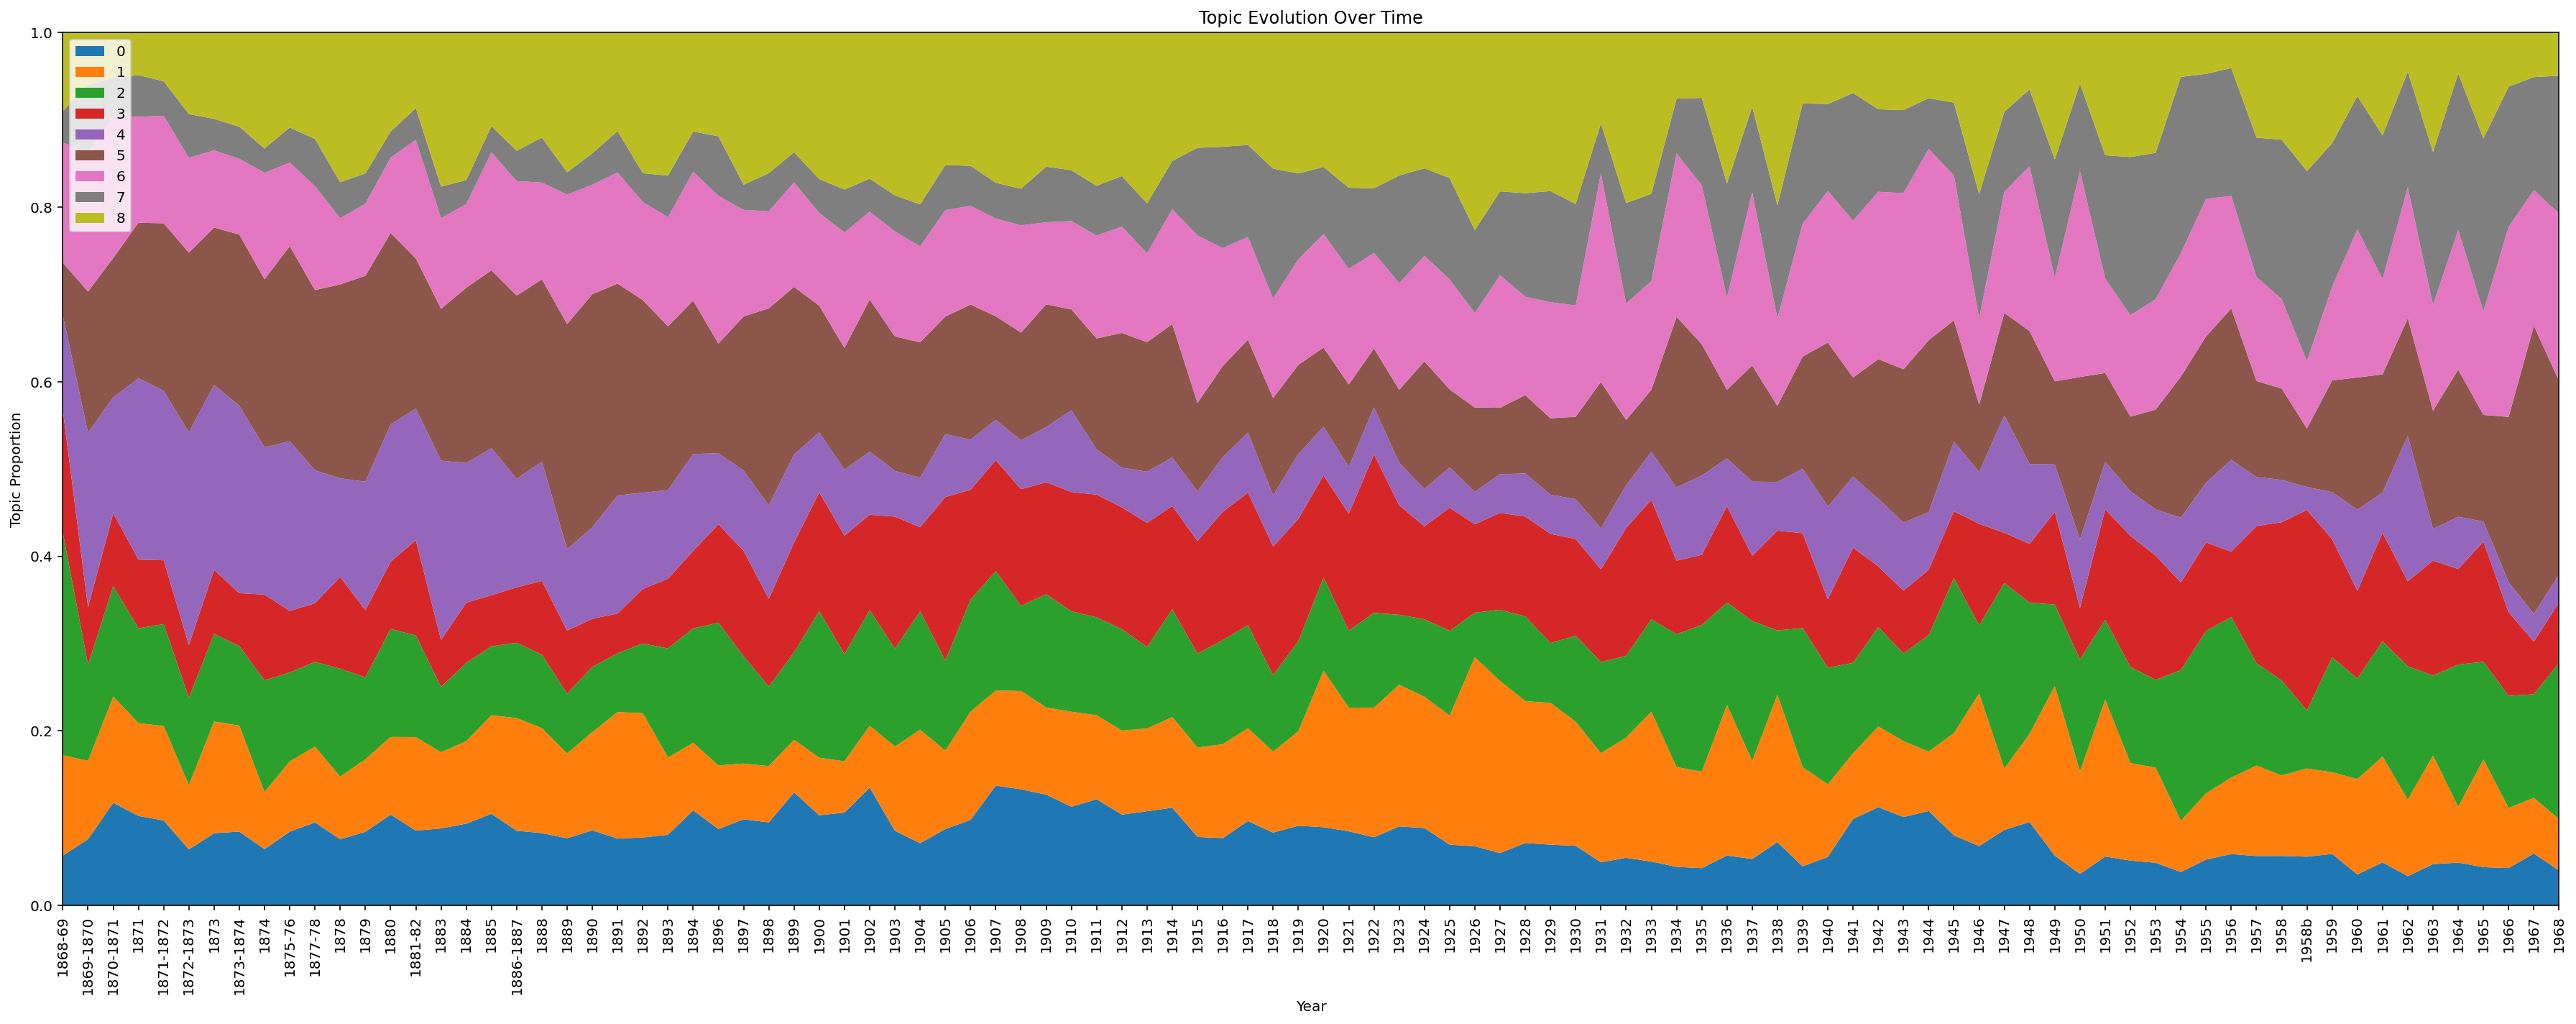

In [16]:
# Plotting the stacked area chart for topic evolution over time
plt.figure(figsize=(25, 10))

# Plotting each topic as a stacked area
# Pass the years as the x-values and the topic proportions for each year as the y-values.
plt.stackplot(topic_distribution_by_year.index, 
              topic_distribution_by_year.values.T, 
              labels=topic_distribution_by_year.columns)

plt.title('Topic Evolution Over Time')

plt.xlabel('Year')
plt.xticks(rotation=90)
plt.margins(x=0)
plt.margins(y=0)
plt.ylabel('Topic Proportion')

plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('imgs/topic_evolution.png', facecolor='white', transparent=False, bbox_inches='tight')
plt.show()

In [17]:
# Extracting the decade from the 'year' column
df['decade'] = df['year'].astype(str).str[:3] + '0s'
df.head()

,year,sentence,dominant_topic,decade
0,1868-69,AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...,7,1860s
1,1868-69,"Whereas, by an Act of Congress, approved the t...",7,1860s
2,1868-69,Beit enacted by the Senate and House of Repres...,5,1860s
3,1868-69,"Upon the passage of this Act, the Governor of ...",4,1860s
4,1868-69,"In the Senate House, the twentysecond day of J...",4,1860s


In [18]:
# Group documents by decade and calculate the average topic distribution for each decade
topic_distribution_by_decade = df.groupby('decade')['dominant_topic'].value_counts(normalize=True).unstack()

# Fill missing values with 0 (if there are decades with no documents)
topic_distribution_by_decade = topic_distribution_by_decade.fillna(0)

# Print the aggregated topic distributions by decade
display(topic_distribution_by_year)

dominant_topic,0,1,2,3,4,5,6,7,8
year,,,,,,,,,
1868-69,0.057143,0.115018,0.254945,0.140659,0.108425,0.060073,0.137729,0.035897,0.090110
1869-1870,0.075924,0.089910,0.109890,0.065934,0.199800,0.161838,0.158841,0.077922,0.059940
1870-1871,0.117694,0.121643,0.126382,0.083728,0.132701,0.159558,0.162717,0.043444,0.052133
1871,0.102550,0.106402,0.108604,0.078701,0.207668,0.178132,0.121262,0.047881,0.048798
1871-1872,0.097421,0.108166,0.116762,0.073066,0.194126,0.191977,0.123209,0.039398,0.055874
...,...,...,...,...,...,...,...,...,...
1964,0.049157,0.063965,0.162896,0.109420,0.059852,0.168449,0.160016,0.179350,0.046894
1965,0.043942,0.123357,0.111886,0.137563,0.023118,0.122121,0.118680,0.197918,0.121415
1966,0.042883,0.068796,0.128467,0.095620,0.034489,0.189416,0.217701,0.160584,0.062044


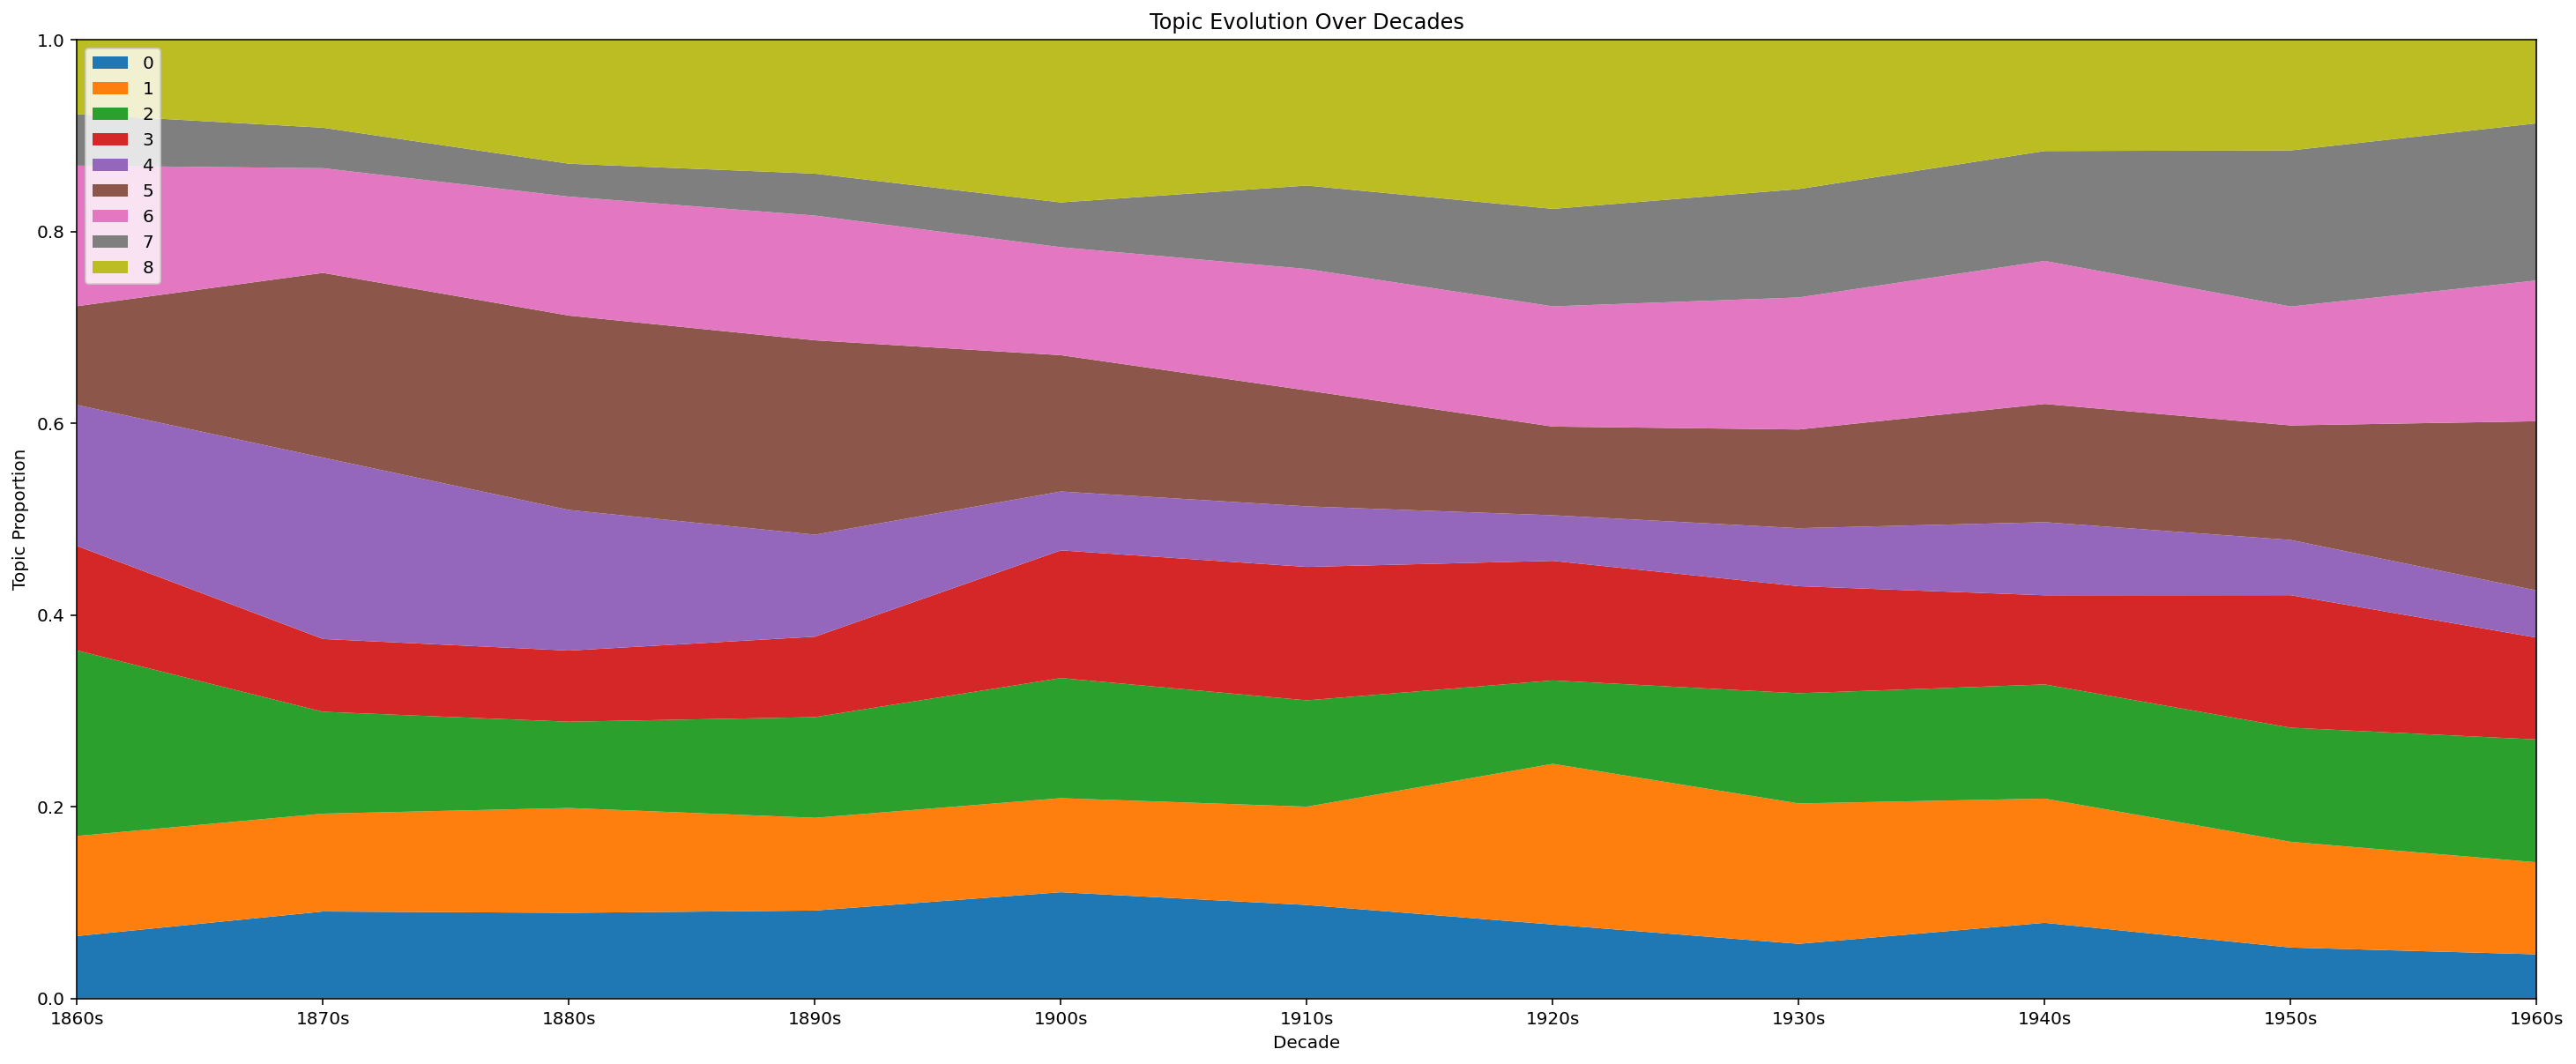

In [19]:
# Plotting the stacked area chart for topic evolution over decades
plt.figure(figsize=(25, 10))

# Plotting each topic as a stacked area
plt.stackplot(topic_distribution_by_decade.index, topic_distribution_by_decade.values.T, labels=topic_distribution_by_decade.columns)

plt.title('Topic Evolution Over Decades')

plt.xlabel('Decade')
plt.margins(x=0)
plt.margins(y=0)
plt.ylabel('Topic Proportion')

plt.legend(loc='upper left')
# plt.tight_layout()
plt.savefig('imgs/topic_evolution_decade.png', facecolor='white', transparent=False, bbox_inches='tight')
plt.show()

<br>